INCOME CODE

Income Codes relate to the amount of income shown on the most recent Form 990 series return filed by the organization.
See table below.

ASSET CODE/INCOME CODE TABLE

&--Income $

0 --0

1 --1 to 9,999

2 --10,000 to 24,999

3 --25,000 to 99,999

4 --100,000 to 499,999

5 --500,000 to 999,999

6 --1,000,000 to 4,999,999

7 --5,000,000 to 9,999,999

8 --10,000,000 to 49,999,999

9 --50,000,000 to greater 

In [1]:
import string
import numpy as np
import random
import time
import pandas as pd
from nltk import word_tokenize, pos_tag
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline

import my own python pipeline, https://github.com/yuxiaosun/capp-455136/tree/master/mlpipe

In [3]:
import os
os.chdir('C:\\Users\\yuxiao\\capp-455136')
from mlpipe import *

1.Prepare Data

In [6]:
df=pd.read_csv('MissionFinance.csv')

In [7]:
df[:1]

,NAME,EIN,PURPOSE,NTEE_CD,NTEE(26),INCOME_CD
0,ACCESSABILITY INC,201594009,"To undertake, aid, promote, guide, manage, coo...",J33,J,6


In [8]:
len(df)

236507

In [9]:
df=df[df.PURPOSE.notnull()]

In [10]:
len(df)

228985

Based on weather a nonprofit is classified, I split the data into train set and test set.

In [11]:
train=df[df['INCOME_CD']!=0].reset_index()

In [12]:
test=df[df['INCOME_CD']==0].reset_index()

In [13]:
len(train)

219579

In [14]:
len(test)

9406

2.Describe Data

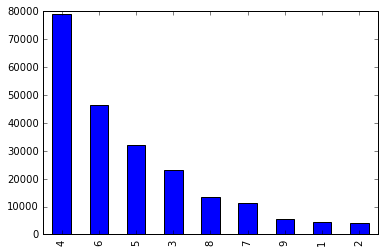

In [15]:
train['INCOME_CD'].value_counts().plot.bar()

As we can see here, the majority of Nonprofits in US has an annual income between 100,000 to 499,999.

3.Feature Generation

First I define large nonprofits as organizations with annual income>$1,000,000, and create a binary variable lnpf, which will be the label for our model.

In [16]:
def discretize_binary(df, x, y, cap):
    df[y]=df[x].apply(lambda x: 1 if x > cap else 0)

In [17]:
discretize_binary(train,'INCOME_CD','lnpf',5)

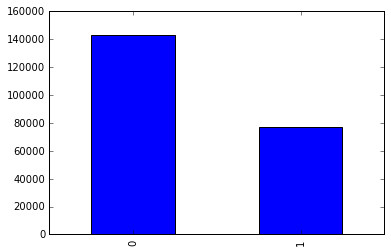

In [18]:
train['lnpf'].value_counts().plot.bar()

Then I generate various features from the mission statements.

In [19]:
mission=train['PURPOSE'].tolist()

In [46]:
def tokenize_and_tag(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    nouns = [token for token, pos in pos_tag(word_tokenize(text)) if pos.startswith('N')]
    return nouns 

In [47]:
tokenize_and_tag(mission[1])

['parents',
 'congregations',
 'children',
 'relationship',
 'God',
 'LRM',
 'materials',
 'delivers',
 'seminars',
 'topic']

In [51]:
tfidf_vectorizer = CountVectorizer(max_df=0.8, min_df=2, tokenizer=tokenize_and_tag, stop_words='english', ngram_range=(1,2))
%time X = tfidf_vectorizer.fit_transform(mission[:10000]) #fit the vectorizer to missions
print(X.shape)

Wall time: 29.7 s
(10000, 10723)


In [30]:
svd = TruncatedSVD(n_components=500, random_state=42)
%time X2 = svd.fit_transform(X)
print(X2.shape)

Wall time: 5.81 s
(10000, 500)


In [38]:
svd.components_

array([ -4.06185867e-04,  -3.72025331e-04,  -1.29872157e-04, ...,
        -1.50570654e-06,   9.90907407e-05,   9.90907407e-05])

In [52]:
df2=pd.DataFrame(X.A, columns=tfidf_vectorizer.get_feature_names())

In [53]:
df2[:5]

,aa,aaf,abilities,abilities groups,abilities incomes,abilities leadership,abilities origins,abilities races,ability,ability boys,...,youth washington,youth work,youths,youths adults,youths families,youths parents,youths sports,ywca,ywca racism,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df2.to_csv('features.csv',index=False)

Display the features generated. "'s" and "'s mission" seems to be bad features, so I drop them.

In [ ]:
df2=pd.read_csv('features.csv')

In [ ]:
df2.columns

In [ ]:
df2.drop(df2.columns[:2],axis=1,inplace=True)

In [ ]:
df2.columns

5.Model and Evaluation

In [ ]:
from __future__ import print_function
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

# turn the data in a (samples, feature) matrix:
n_samples = len(train)
X = df2
y = train['NTEE(26)']

# Split the dataset in 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Set the parameters by cross-validation
parameters = {'n_neighbors': [5,10,25,50,100],'weights': ['uniform','distance'],
              'algorithm': ['auto','ball_tree','kd_tree']}

scores = ['accuracy','f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(KNeighborsClassifier(n_neighbors=3), param_grid=parameters, scoring=score)

    clf.fit(X_train, y_train)

    print("Best parameters set found on training set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on training set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full training set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

L=3
X, y = make_multilabel_classification(n_classes=L, n_labels=2,
                                  allow_unlabeled=True,
                                  random_state=1, return_indicator=True)    
model_to_set = OneVsRestClassifier(SVC())

parameters = {
    "estimator__C": [1,2,4,8],
    "estimator__degree":[1, 2, 3, 4],
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters,
                             scoring='f1')

model_tunning.fit(df2, df['NTEE(26)'])

print model_tunning.best_score_
print model_tunning.best_params_

In [ ]:
Conclusion
